In [171]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [172]:
# import SQL to bring data
engine = create_engine("sqlite:///Downloads/metis/mta_data.db")
insp = inspect(engine)

In [173]:
# Bring all the data from mta_data.db
mta_data = pd.read_sql('SELECT * FROM mta_data WHERE STATION is not null;', engine)

In [174]:
mta_data.columns = [column.strip() for column in mta_data.columns]
mta_data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [175]:
# Added DATE_TIME column
mta_data["DATE_TIME"] = pd.to_datetime(mta_data.DATE + " " + mta_data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
mta_data.sort_values(by=['DATE_TIME'], inplace=True)

In [176]:
mta_data["DATE"]= pd.to_datetime(mta_data["DATE"])
mta_data = mta_data.sort_values(['C/A', 'UNIT', 'SCP', 'STATION','DATE_TIME'])
mta_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
2513079,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,00:00:00,REGULAR,7578734,2590325,2021-05-29 00:00:00
2513080,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,04:00:00,REGULAR,7578740,2590327,2021-05-29 04:00:00
2513081,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,08:00:00,REGULAR,7578749,2590340,2021-05-29 08:00:00
2513082,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,12:00:00,REGULAR,7578789,2590386,2021-05-29 12:00:00
2513083,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-05-29,16:00:00,REGULAR,7578897,2590418,2021-05-29 16:00:00


In [177]:
#Get rid of duplicates
mta_data.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE" ,"TIME"], inplace=True)

In [178]:
Daily_Entries = (mta_data.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).ENTRIES.last())


In [179]:
Daily_Entries[["PREV_DATE", "PREV_ENTRIES"]] = Daily_Entries.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1))

<ipython-input-179-b3ffa90bf594>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Daily_Entries[["PREV_DATE", "PREV_ENTRIES"]] = Daily_Entries.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1))


In [180]:
Daily_Entries.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
Daily_Entries[Daily_Entries["ENTRIES"] < Daily_Entries["PREV_ENTRIES"]].head()
Daily_Entries[Daily_Entries["ENTRIES"] < Daily_Entries["PREV_ENTRIES"]].groupby(["C/A", "UNIT", "SCP", "STATION"]).size()

C/A   UNIT  SCP       STATION        
A011  R080  01-03-00  57 ST-7 AV         90
A013  R081  01-06-01  49 ST               1
A014  R081  02-00-00  49 ST               1
A049  R088  02-00-02  CORTLANDT ST        1
            02-05-00  CORTLANDT ST       34
                                         ..
R621  R060  00-06-00  EASTN PKWY-MUSM     1
R622  R123  00-00-00  FRANKLIN AV        90
R633  R068  00-00-01  VAN SICLEN AV       1
R646  R110  01-00-02  FLATBUSH AV-B.C     1
R730  R431  00-00-04  EASTCHSTER/DYRE    90
Length: 197, dtype: int64

In [181]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [182]:
Daily_Entries["DAILY_ENTRIES"] = Daily_Entries.apply(get_daily_counts, axis=1, max_counter=6000)

114 8621.0
427 67581.0
39 7762.0
44 13117.0
187 30721.0
93 765803.0
5 150038.0
353 8049630.0
458752 24.0
262309 279345.0
393219 459438.0
166 20146.0
458754 262214.0
8 458758.0
167790157 702266.0
48 8724126.0
65 106396.0
458754 262144.0
393216 458752.0
1946307751 1946273868.0
42 72848.0
14779 8538.0
100 91332.0
733336 725935.0
68315 62009.0
0 26347.0
0 28318.0
393216 728.0
1 327690.0
327680 262144.0
166 89658.0
241 59609.0
242 33783.0
153 1604971.0
5946 4298704.0
0 117440512.0
83 366981.0
517037 484260.0
484283 517037.0
331 500527.0
327975 7577027.0
85 490316.0
67109632 14.0
327682 67109640.0
15 67109632.0
12517611 82.0
36 1198448.0
103 305512.0
46 5405351.0
687970551 19471253.0
458753 393246.0
200 705357551.0
40298 46684.0
1076 7489966.0
62 74079.0
16777220 1037157.0
6 16034831.0
34 692662.0
458814 271001.0
327682 786526.0
327680 0.0
932 628772.0
386 6213955.0
442 656520.0
37 1950780.0
443 15689395.0
10 558268.0
2 33030303.0
772 239100.0
421 114067.0
486 26298.0
0 10295.0
10 21771.0
17

In [183]:
Daily_Entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2021-05-30,7579275,2021-05-29,7579021.0,254.0
2,A002,R051,02-00-00,59 ST,2021-05-31,7579593,2021-05-30,7579275.0,318.0
3,A002,R051,02-00-00,59 ST,2021-06-01,7580178,2021-05-31,7579593.0,585.0
4,A002,R051,02-00-00,59 ST,2021-06-02,7580754,2021-06-01,7580178.0,576.0
5,A002,R051,02-00-00,59 ST,2021-06-03,7581328,2021-06-02,7580754.0,574.0


In [184]:
Daily_Exits = (mta_data.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).EXITS.last())


In [185]:
Daily_Exits[["PREV_DATE", "PREV_EXITS"]] = Daily_Exits.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"].apply(lambda grp: grp.shift(1))

<ipython-input-185-cfea49f69739>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Daily_Exits[["PREV_DATE", "PREV_EXITS"]] = Daily_Exits.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"].apply(lambda grp: grp.shift(1))


In [186]:
Daily_Exits

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2021-05-29,2590439,NaT,NaN
1,A002,R051,02-00-00,59 ST,2021-05-30,2590548,2021-05-29,2590439.0
2,A002,R051,02-00-00,59 ST,2021-05-31,2590641,2021-05-30,2590548.0
3,A002,R051,02-00-00,59 ST,2021-06-01,2590917,2021-05-31,2590641.0
4,A002,R051,02-00-00,59 ST,2021-06-02,2591200,2021-06-01,2590917.0
...,...,...,...,...,...,...,...,...
454566,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-08-23,614,2021-08-22,613.0
454567,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-08-24,614,2021-08-23,614.0
454568,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-08-25,614,2021-08-24,614.0
454569,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-08-26,614,2021-08-25,614.0


In [187]:
Daily_Exits.dropna(subset=["PREV_DATE"], axis=0, inplace=True)


In [188]:
Daily_Exits[Daily_Exits["EXITS"] < Daily_Exits["PREV_EXITS"]].head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS
3550,A011,R080,01-03-00,57 ST-7 AV,2021-05-30,489576428,2021-05-29,489576988.0
3551,A011,R080,01-03-00,57 ST-7 AV,2021-05-31,489575934,2021-05-30,489576428.0
3552,A011,R080,01-03-00,57 ST-7 AV,2021-06-01,489575062,2021-05-31,489575934.0
3553,A011,R080,01-03-00,57 ST-7 AV,2021-06-02,489574155,2021-06-01,489575062.0
3554,A011,R080,01-03-00,57 ST-7 AV,2021-06-03,489573296,2021-06-02,489574155.0


In [189]:
Daily_Exits[Daily_Exits["EXITS"] < Daily_Exits["PREV_EXITS"]].groupby(["C/A", "UNIT", "SCP", "STATION"]).size()


C/A   UNIT  SCP       STATION        
A011  R080  01-03-00  57 ST-7 AV         90
A013  R081  01-06-01  49 ST               1
A014  R081  02-00-00  49 ST               1
A049  R088  02-00-02  CORTLANDT ST        1
A050  R088  00-05-01  CORTLANDT ST        1
                                         ..
R621  R060  00-06-00  EASTN PKWY-MUSM     1
R622  R123  00-00-00  FRANKLIN AV        90
R633  R068  00-00-01  VAN SICLEN AV       1
R646  R110  01-00-02  FLATBUSH AV-B.C     1
R728  R226  00-05-01  GUN HILL RD         1
Length: 176, dtype: int64

In [190]:
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [191]:
Daily_Exits["DAILY_EXITS"] = Daily_Exits.apply(get_daily_counts, axis=1, max_counter=6000)


232 34338.0
56 10571.0
4628405 4609822.0
4640239 4628405.0
106 25502.0
218 1653807.0
0 9739.0
165 2357391.0
56 8633.0
306 13866.0
268473848 1083083.0
65 8512839.0
602 1025567.0
259 160229.0
576 205674.0
676 274285.0
323 161084.0
289 11781.0
384 20396.0
163 43656.0
1145 152516.0
94 561746.0
3870 494138.0
306 1150397.0
27874706 27867195.0
754680 747743.0
220 477096.0
106 2004675.0
168 319261.0
14090596 149.0
79 1502382.0
493 92244.0
50 1851686.0
1174467683 4611970.0
465 705468481.0
239 1671513.0
60 18831.0
13 415998.0
226 7303975.0
278 6525554.0
116 22636.0
1046 547475.0
70 767335.0
1624 2136659.0
1179 3095180.0
436 8944151.0
327681 22589.0
0 654311429.0
181 39215.0
1171 370123.0
1114 15135.0
1002 71711.0
7 16336.0
792 13944.0
487 399602.0
133 110581.0
10 13287.0
1373 983880.0
149224 68650.0
68843 149224.0
268 24700.0
186 7361.0
214 15322.0
0 204513.0
108 31334.0
287540 4132.0
6549 287540.0
211 734409.0
22 41419.0
31 14578.0
178 287893.0
730 36430.0
10 8775.0
2 73782.0
29 12712.0
1 25695

In [192]:
Daily_Exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,2021-05-30,2590548,2021-05-29,2590439.0,109.0
2,A002,R051,02-00-00,59 ST,2021-05-31,2590641,2021-05-30,2590548.0,93.0
3,A002,R051,02-00-00,59 ST,2021-06-01,2590917,2021-05-31,2590641.0,276.0
4,A002,R051,02-00-00,59 ST,2021-06-02,2591200,2021-06-01,2590917.0,283.0
5,A002,R051,02-00-00,59 ST,2021-06-03,2591445,2021-06-02,2591200.0,245.0


In [193]:
mta_entries = (Daily_Entries.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum().reset_index())
mta_entries.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2021-05-30,4575.0
1,1 AV,2021-05-31,4943.0
2,1 AV,2021-06-01,7487.0
3,1 AV,2021-06-02,7993.0
4,1 AV,2021-06-03,7844.0


In [194]:
mta_exits = (Daily_Exits.groupby(['STATION','DATE'])['DAILY_EXITS'].sum().reset_index())
mta_exits.head()

,STATION,DATE,DAILY_EXITS
0,1 AV,2021-05-30,8830.0
1,1 AV,2021-05-31,8936.0
2,1 AV,2021-06-01,12730.0
3,1 AV,2021-06-02,13067.0
4,1 AV,2021-06-03,13031.0


In [195]:
mta_entries_exits = pd.merge(mta_entries, mta_exits, how='outer')
mta_entries_exits.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS
0,1 AV,2021-05-30,4575.0,8830.0
1,1 AV,2021-05-31,4943.0,8936.0
2,1 AV,2021-06-01,7487.0,12730.0
3,1 AV,2021-06-02,7993.0,13067.0
4,1 AV,2021-06-03,7844.0,13031.0


In [196]:
mta_entries_exits['TRAFFIC'] = mta_entries_exits['DAILY_ENTRIES'] + mta_entries_exits['DAILY_EXITS']
mta_entries_exits['DOW'] = mta_entries_exits['DATE'].dt.day_name()


In [198]:
mta_entries_exits.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,TRAFFIC,DOW
0,1 AV,2021-05-30,4575.0,8830.0,13405.0,Sunday
1,1 AV,2021-05-31,4943.0,8936.0,13879.0,Monday
2,1 AV,2021-06-01,7487.0,12730.0,20217.0,Tuesday
3,1 AV,2021-06-02,7993.0,13067.0,21060.0,Wednesday
4,1 AV,2021-06-03,7844.0,13031.0,20875.0,Thursday


In [199]:
stations_traffic = mta_entries_exits[['STATION', 'DATE', 'TRAFFIC']]
stations_traffic.head()

,STATION,DATE,TRAFFIC
0,1 AV,2021-05-30,13405.0
1,1 AV,2021-05-31,13879.0
2,1 AV,2021-06-01,20217.0
3,1 AV,2021-06-02,21060.0
4,1 AV,2021-06-03,20875.0


In [200]:
top10_stations = stations_traffic.groupby(['STATION'])['TRAFFIC'].sum().reset_index()


In [201]:
top10_stations = top10_stations.sort_values(by='TRAFFIC',ascending=False).round().head(10)
top10_stations

,STATION,TRAFFIC
61,34 ST-PENN STA,9261899.0
59,34 ST-HERALD SQ,7088238.0
233,GRD CNTRL-42 ST,6823255.0
110,86 ST,6152779.0
68,42 ST-PORT AUTH,5945175.0
14,14 ST-UNION SQ,5906665.0
46,23 ST,5583519.0
9,125 ST,5431391.0
353,TIMES SQ-42 ST,5195669.0
226,FULTON ST,4792465.0


In [202]:
selection = top10_stations['STATION']
selection = list(selection)
selection

['34 ST-PENN STA',
 '34 ST-HERALD SQ',
 'GRD CNTRL-42 ST',
 '86 ST',
 '42 ST-PORT AUTH',
 '14 ST-UNION SQ',
 '23 ST',
 '125 ST',
 'TIMES SQ-42 ST',
 'FULTON ST']

In [203]:
top10_stations_traffic = mta_entries_exits[mta_entries_exits.STATION.isin(selection)].round()
top10_stations_traffic

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,TRAFFIC,DOW
810,125 ST,2021-05-30,14195.0,20181.0,34376.0,Sunday
811,125 ST,2021-05-31,18482.0,24021.0,42503.0,Monday
812,125 ST,2021-06-01,30357.0,36055.0,66412.0,Tuesday
813,125 ST,2021-06-02,30707.0,36784.0,67491.0,Wednesday
814,125 ST,2021-06-03,29193.0,34890.0,64083.0,Thursday
...,...,...,...,...,...,...
31827,TIMES SQ-42 ST,2021-08-23,20563.0,30047.0,50610.0,Monday
31828,TIMES SQ-42 ST,2021-08-24,27064.0,37511.0,64575.0,Tuesday
31829,TIMES SQ-42 ST,2021-08-25,27971.0,38172.0,66143.0,Wednesday
31830,TIMES SQ-42 ST,2021-08-26,27518.0,37876.0,65394.0,Thursday


In [204]:
top10_stations_weekday = top10_stations_traffic.groupby(['STATION','DOW'])['TRAFFIC'].mean().round().reset_index()
top10_stations_weekday

,STATION,DOW,TRAFFIC
0,125 ST,Friday,67980.0
1,125 ST,Monday,60055.0
2,125 ST,Saturday,51868.0
3,125 ST,Sunday,41032.0
4,125 ST,Thursday,67322.0
...,...,...,...
65,TIMES SQ-42 ST,Saturday,53181.0
66,TIMES SQ-42 ST,Sunday,43402.0
67,TIMES SQ-42 ST,Thursday,63779.0
68,TIMES SQ-42 ST,Tuesday,62634.0


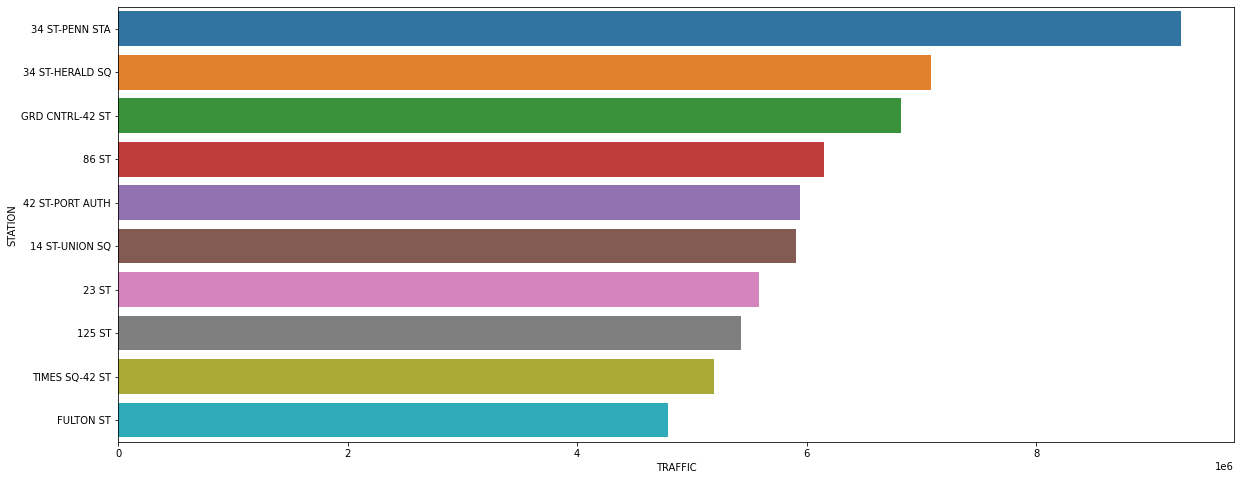

In [205]:
plt.figure(figsize=(20,8))
sns.barplot(x = 'TRAFFIC',y='STATION',data = top10_stations, ci=None);

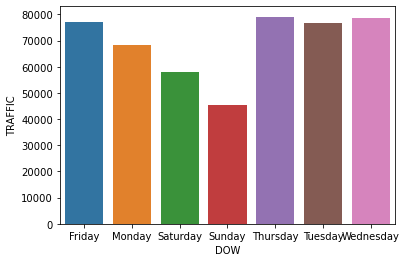

In [206]:
sns.barplot(x = 'DOW',y='TRAFFIC',data = top10_stations_weekday, ci=None);


<AxesSubplot:xlabel='DOW', ylabel='TRAFFIC'>

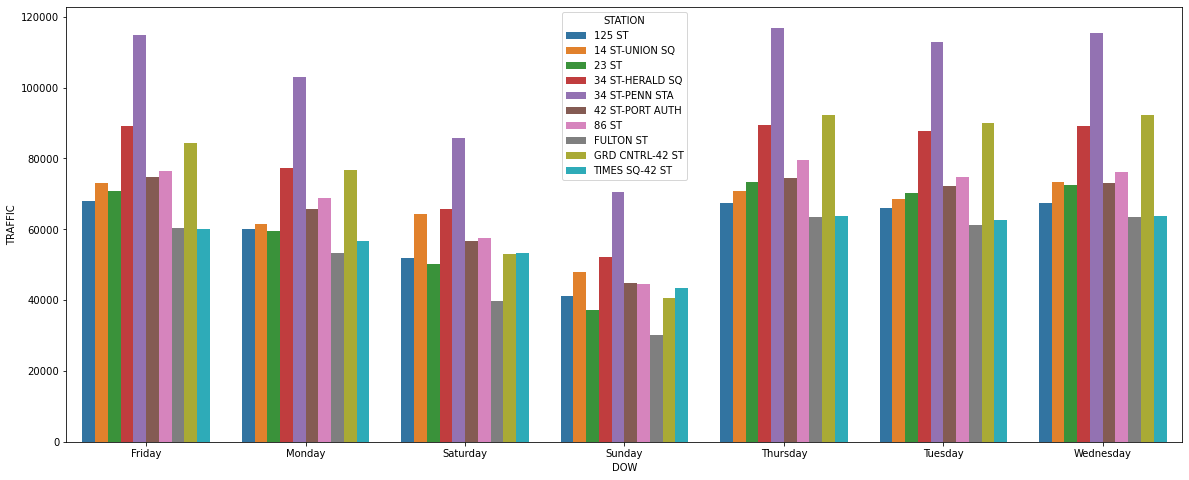

In [207]:
plt.figure(figsize=(20,8))
sns.barplot(x='DOW', y="TRAFFIC" ,hue="STATION", data=top10_stations_weekday, ci=None)
